<a href="https://colab.research.google.com/github/simulate111/mini-project-2-Abo/blob/main/MIniProject2Reza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Conv1D, SimpleRNN
from zipfile import ZipFile
import urllib.request
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-02-14 19:07:08.524167: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-14 19:07:08.798155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-14 19:07:08.798191: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-14 19:07:08.869063: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 19:07:09.804690: W tensorflow/stream_executor/platform/de

In [2]:
file_path = 'https://raw.githubusercontent.com/simulate111/mini-project-2-Abo/main/Sentiment140.tenPercent.sample.tweets.tsv'
df = pd.read_csv(file_path, sep='\t', header=0)
display(df.head())
df.info()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sentiment_label  160000 non-null  int64 
 1   tweet_text       160000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [3]:
sentiment_label_counts = df['sentiment_label'].value_counts()
print(sentiment_label_counts)

0    80000
4    80000
Name: sentiment_label, dtype: int64


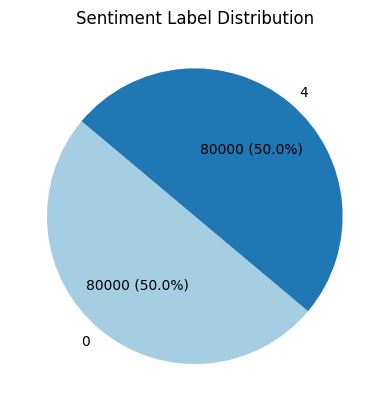

In [4]:
sentiment_label_counts = df['sentiment_label'].value_counts()
plt.pie(sentiment_label_counts, labels=sentiment_label_counts.index, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sentiment_label_counts.sum() / 100, p),
        startangle=140, colors=plt.cm.Paired.colors)
plt.title('Sentiment Label Distribution')
plt.show()

In [5]:
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
sentiment_label    0
tweet_text         0
dtype: int64


In [6]:
df['text_length'] = df['tweet_text'].apply(len)
print("Text Length Summary:")
print(df['text_length'].describe())

Text Length Summary:
count    160000.000000
mean         74.113481
std          36.440383
min           6.000000
25%          44.000000
50%          69.000000
75%         104.000000
max         186.000000
Name: text_length, dtype: float64


In [7]:
df['sentiment_label'] = df['sentiment_label'].replace({4: 1})
display(df.head())

,sentiment_label,tweet_text,text_length
0,1,"@elephantbird Hey dear, Happy Friday to You A...",85
1,1,Ughhh layin downnnn Waiting for zeina to co...,58
2,0,"@greeniebach I reckon he'll play, even if he's...",116
3,0,@vaLewee I know! Saw it on the news!,37
4,0,very sad that http://www.fabchannel.com/ has c...,118


In [8]:
#Cleaning the data
def clean_tweet(tweet):
    tweet = re.sub(r'@[\w]+', '', tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'[^A-Za-z0-9]+', ' ', tweet)
    tweet = ' '.join(tweet.split())
    return tweet
df['cleaned_tweet'] = df['tweet_text'].apply(clean_tweet)
display(df[['tweet_text', 'cleaned_tweet']].head())

,tweet_text,cleaned_tweet
0,"@elephantbird Hey dear, Happy Friday to You A...",Hey dear Happy Friday to You Already had your ...
1,Ughhh layin downnnn Waiting for zeina to co...,Ughhh layin downnnn Waiting for zeina to cook ...
2,"@greeniebach I reckon he'll play, even if he's...",I reckon he ll play even if he s not 100 but i...
3,@vaLewee I know! Saw it on the news!,I know Saw it on the news
4,very sad that http://www.fabchannel.com/ has c...,very sad that has closed down One of the few w...


In [9]:
# Check for null or empty content
null_cleaned_tweets = df[df['cleaned_tweet'].isnull() | (df['cleaned_tweet'] == '')]
print("Summary of Null or Empty Cleaned Tweets:")
print(null_cleaned_tweets.info())
print(f"Null values: \n\n{df.isna().sum()}")

Summary of Null or Empty Cleaned Tweets:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 183 to 159158
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentiment_label  330 non-null    int64 
 1   tweet_text       330 non-null    object
 2   text_length      330 non-null    int64 
 3   cleaned_tweet    330 non-null    object
dtypes: int64(2), object(2)
memory usage: 12.9+ KB
None
Null values: 

sentiment_label    0
tweet_text         0
text_length        0
cleaned_tweet      0
dtype: int64


### Tokienization

In [10]:
tokenized_sequences = df['cleaned_tweet']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_sequences)
# Convert text data to sequences of integers
sequences = tokenizer.texts_to_sequences(tokenized_sequences)
print("Sample Sequences:", sequences[:2])
print(f"Word index length: {len(tokenizer.word_index)}")
some_words = list(tokenizer.word_index.keys())[:10]
print(f"Some words: {some_words}")

Sample Sequences: [[150, 636, 120, 322, 2, 8, 206, 66, 45, 1748, 12, 2193, 10, 358], [2194, 3973, 20681, 298, 10, 29220, 2, 1155, 523]]
Word index length: 70393
Some words: ['i', 'to', 'the', 'a', 'my', 'and', 'it', 'you', 'is', 'for']


In [11]:
X = sequences
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train:", len(X_train))
print("X_test:", len(X_test))
print(" y_train:", len(y_train))
print("y_test:", len(y_test))

X_train: 128000
X_test: 32000
 y_train: 128000
y_test: 32000


In [12]:
max_token_length = max(len(sequence) for sequence in tokenized_sequences)
print(f"Maximum Token Length: {max_token_length}")

Maximum Token Length: 169


### NEural network

In [13]:
max_sequence_length = max(len(sequence) for sequence in X_train)
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_sequence_length)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_sequence_length)
glove_url = 'https://huggingface.co/stanfordnlp/glove/resolve/main/glove.twitter.27B.zip'
# Create a directory to store the download files
download_dir = 'glove_twitter'
os.makedirs(download_dir, exist_ok=True)
zip_file_path = os.path.join(download_dir, 'glove.twitter.27B.zip')
urllib.request.urlretrieve(glove_url, zip_file_path)
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(download_dir)

glove_embeddings_path = os.path.join(download_dir, 'glove.twitter.27B.200d.txt')
# Load the pre-trained GloVe
embeddings_index = {}
with open(glove_embeddings_path, 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [14]:
embedding_dim = len(embeddings_index.get('a'))
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [15]:
# Neural network model with GloVe embeddings
model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),
    Flatten(), Dense(1, activation='sigmoid')])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_padded, y_train, epochs=10, validation_data=(X_test_padded, y_test))

2024-02-14 19:09:32.924565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-02-14 19:09:32.924613: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-02-14 19:09:32.924661: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-8aba36e2-8533-4926-b208-ccdfd6b36899): /proc/driver/nvidia/version does not exist
2024-02-14 19:09:32.924976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-14 19:09:33.059958: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Al

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 46, 200)           14078800  
                                                                 
 flatten (Flatten)           (None, 9200)              0         
                                                                 
 dense (Dense)               (None, 1)                 9201      
                                                                 
Total params: 14,088,001
Trainable params: 9,201
Non-trainable params: 14,078,800
_________________________________________________________________


In [17]:
plot_model(model, to_file='rnn_model.png', show_shapes=True, show_layer_names=True, expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


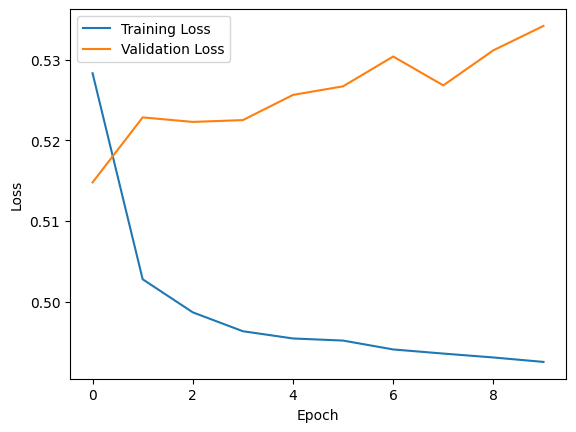

In [18]:
# Plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Convolutional Neural Network (CNN):

In [19]:
modelCNN = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),
    Conv1D(128, 5, activation='relu'), Conv1D(128, 3, activation='relu'), Dense(64, activation='relu'), Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')])

modelCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
historyCNN = modelCNN.fit(X_train_padded, y_train, epochs=10, validation_data=(X_test_padded, y_test))
test_loss, test_accuracy = modelCNN.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

2024-02-14 19:11:12.957185: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 56315200 exceeds 10% of free system memory.
Epoch 1/10
4000/4000 [==============================] - 149s 37ms/step - loss: 0.6665 - acc: 0.5587 - val_loss: 0.6616 - val_acc: 0.5634
Epoch 2/10
4000/4000 [==============================] - 151s 38ms/step - loss: 0.6599 - acc: 0.5647 - val_loss: 0.6602 - val_acc: 0.5647
Epoch 3/10
4000/4000 [==============================] - 144s 36ms/step - loss: 0.6561 - acc: 0.5693 - val_loss: 0.6612 - val_acc: 0.5647
Epoch 4/10
4000/4000 [==============================] - 144s 36ms/step - loss: 0.6523 - acc: 0.5728 - val_loss: 0.6616 - val_acc: 0.5645
Epoch 5/10
4000/4000 [==============================] - 143s 36ms/step - loss: 0.6485 - acc: 0.5756 - val_loss: 0.6631 - val_acc: 0.5640
Epoch 6/10
4000/4000 [==============================] - 145s 36ms/step - loss: 0.6449 - acc: 0.5778 - val_loss: 0.6641 - val_acc: 0.5627
Epoch 7/10
4000/4000 [================

In [20]:
modelCNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 46, 200)           14078800  
                                                                 
 conv1d (Conv1D)             (None, 42, 128)           128128    
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 128)           49280     
                                                                 
 dense_1 (Dense)             (None, 40, 64)            8256      
                                                                 
 dense_2 (Dense)             (None, 40, 128)           8320      
                                                                 
 dense_3 (Dense)             (None, 40, 1)             129       
                                                                 
Total params: 14,272,913
Trainable params: 194,113
Non

In [21]:
plot_model(modelCNN, to_file='rnn_model.png', show_shapes=True, show_layer_names=True, expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


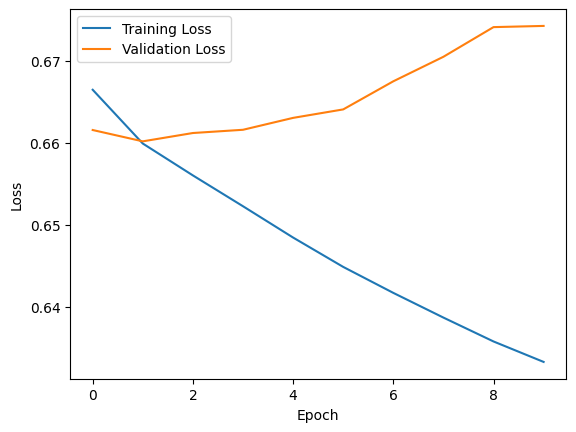

In [22]:
# Plot
plt.plot(historyCNN.history['loss'], label='Training Loss')
plt.plot(historyCNN.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

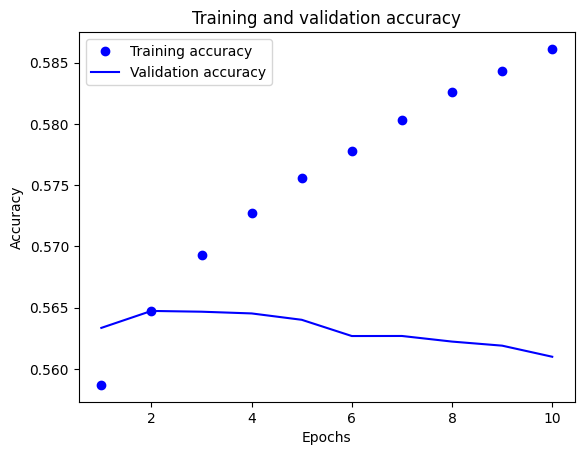

In [23]:
accuracy = historyCNN.history['acc']
val_accuracy = historyCNN.history['val_acc']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### RNN

In [36]:
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
modelRNN = Sequential()
modelRNN.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_length))
modelRNN.add(SimpleRNN(units=64, activation='relu', return_sequences=True))
modelRNN.add(SimpleRNN(units=128, activation='relu', return_sequences=True))
modelRNN.add(Dense(units=1, activation='sigmoid'))
modelRNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [35]:
epochs = 5
historyRNN = modelRNN.fit(X_train_padded, y_train, epochs=epochs, validation_data=(X_test_padded, y_test))

Epoch 1/5
  27/4000 [..............................] - ETA: 25:12 - loss: 0.6941 - acc: 0.5059

KeyboardInterrupt: 

In [ ]:
test_loss, test_accuracy = modelRNN.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

In [ ]:
plt.plot(historyRNN.history['loss'])
plt.plot(historyRNN.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
plot_model(modelRNN, to_file='rnn_model.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
accuracy = historyRNN.history['acc']
val_accuracy = historyRNN.history['val_acc']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8aba36e2-8533-4926-b208-ccdfd6b36899' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>